# FIE for Dirichlet BVP in a circle with Polynomial Gauss rule

In [1]:
import numpy as np
import scipy.integrate as integrate
#import scipy.interpolate as interp
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import math
import time


In [2]:
def K_matrix(phis, taus):
    """Returns the Kernel for BIE as bivariate function
    """
    return np.ones((len(phis), len(taus))) * 1/(2*np.pi)


def ke(r, phi, theta):
    """Returns the kernel function to find 
    the solution of BIE for the hole space -
    three-variate function"""

    kernel = (1 - r*np.cos(theta-phi)) / \
                 (r**2 + 1 - 2*r*np.cos(theta-phi))
    return kernel


def h(phi):
    """Returns the right-hand side univariate function 
    in BIE"""

    return np.cos(2*phi)


def E(r, phi):
    """The exact solution of the Dirichlet BVP
    for Laplace equation"""

    return (r**2) * np.cos(2*phi)

In [3]:
def taus_omegas_Gauss(a, b, x, w):
    taus = (b - a)*0.5 * x + (a + b)*0.5
    omegas = w*(b - a)*0.5
    
    return taus, omegas 

## Polynomial Gauss

In [4]:
def test(N):

    a = 0
    b = 2 * np.pi

    print(N)    # number of macroblocks
    order = 2   # Gaussian quadrature order

    phis =  np.pi   #np.linspace(0, 2*np.pi, 300)
    rs =    0.99   #np.linspace(1e-3, 1, 200, endpoint=False)

    #### define taus, omegas for integration with macroblocks

    x, w = np.polynomial.legendre.leggauss(order)
    
    interval = np.linspace(a, b, N+1)
    taus = []; omegas = []
    for a_, b_ in zip(interval[:-1], interval[1:]):
        t_, o_ = taus_omegas_Gauss(a_, b_, x, w)
        taus.append(t_)
        omegas.append(o_)
    taus = np.ravel(taus)
    omegas = np.ravel(omegas)

    #### block matrix and solution for sigmas

    Ko_blocks = []
    for taus_, omegas_ in zip(taus.reshape((N, order)),
                              omegas.reshape((N, order))):
        Ko_blocks.append(K_matrix(taus_, taus_) * omegas_)
    Ko = scipy.linalg.block_diag(*Ko_blocks)

    sigmas = np.dot(np.linalg.inv(np.identity(len(taus)) + Ko), 2*h(taus))

    #### Nystrom algorithm

    sigmas_ns = 2 * h(taus) - (K_matrix(taus, taus) * omegas) @ sigmas
    
    
    #### final integration

    rs_m, phis_m, thetas_m = np.meshgrid(rs, phis, taus, indexing='ij')
    ke_matrix = ke(rs_m, phis_m, thetas_m)

    integral = ((ke_matrix * sigmas_ns) * omegas).sum(axis=-1)

    rs_m, phis_m = np.meshgrid(rs, phis, indexing='ij')
    #x_mesh, y_mesh = rs_m * np.cos(phis_m), rs_m * np.sin(phis_m)
    u_mesh = 1/(2*np.pi) * integral

    E_mesh = E(rs_m, phis_m)
    
    #l2errors = np.sqrt(np.sum(np.power((E_mesh - u_mesh)*(phis[1]-phis[0])*(rs[1]-rs[0]),2)))

    return (abs(E_mesh - u_mesh)).max() #, np.mean(abs(E_mesh - u_mesh)) #, l2errors

In [5]:
El = 8
errors = np.zeros(El)
me = np.zeros(El)
l2err = np.zeros(El)
for i in range(El):
    Ns = 7*2**i
    errors[i] = test(Ns)

7
14
28
56
112
224
448
896


In [6]:
ns = 14*2**np.arange(El) 
ms = ns 
errs_rel = errors[:-1] / errors[1:]
errs_log = np.log2(errs_rel)

In [7]:
msg = '{:>4}\t{:>8}\t{:>12}'.format('m', 'Max Error', 'Log_2(Max Error)')

print(msg)
print('-'*(len(msg)+6*4))

for i in range(El): 
    if i == 0:
        print('{:4d}\t{:.2e}\t{:>12}'.format(ms[i], errors[i],  ''))
        
    else:
        print('{:4d}\t{:.2e}\t{:.2e}'.format(ms[i], errors[i], errs_log[i-1]))

   m	Max Error	Log_2(Max Error)
-------------------------------------------------------
  14	9.44e-01	            
  28	8.17e-01	2.08e-01
  56	6.43e-01	3.44e-01
 112	3.57e-01	8.50e-01
 224	5.73e-02	2.64e+00
 448	2.97e-02	9.50e-01
 896	5.11e-03	2.54e+00
1792	5.91e-05	6.44e+00


In [8]:
errors

array([9.43549343e-01, 8.16660422e-01, 6.43367712e-01, 3.56890453e-01,
       5.73215546e-02, 2.96762120e-02, 5.11455189e-03, 5.90724676e-05])

In [9]:
Sp=[2.55913381e+01, 1.18302133e+01, 7.22497423e+00,
       3.43764344e+00, 1.36435065e+00, 4.06104825e-01, 5.99090938e-02,
       1.60654739e-03]
len(Sp)

8

In [10]:
len(errors[:-1])

7

In [11]:
errors[:-1]

array([0.94354934, 0.81666042, 0.64336771, 0.35689045, 0.05732155,
       0.02967621, 0.00511455])

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

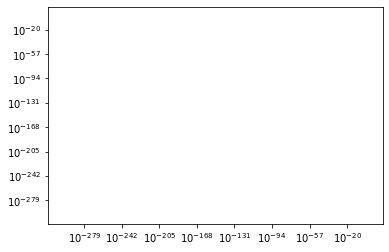

In [12]:
plt.yscale('log')
plt.xscale('log')
h1, = plt.plot(ms[:-1], Sp, '.-', label='$B$ = 3H')
h2, = plt.plot(ms[:-1], errors[:-1], '.-', label='$B$ = G2')
plt.legend(handles=[h1, h2], loc=3, fancybox=True)
plt.xlabel("Quaprature points")
plt.ylabel("Max error")

In [ ]:
h1, = plt.plot(ms, Gau, 'bo', label='$B$ = G3')
plt.plot(ms, Gau, 'b-' )
h2, = plt.plot(ms, Sp, 'ro', label='$B$ = 5H')
plt.plot(ms, Sp, 'r-' )
plt.xlabel("Quaprature points")
plt.ylabel("Error")
plt.yscale('log')
plt.legend(handles=[h1, h2], loc=3, fancybox=True)